In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import stats
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import random

import test.utils as test

In [2]:
scv.set_figure_params(dpi=100, color_map = 'viridis_r')
scv.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.8.0 umap==0.4.1 numpy==1.19.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9


In [3]:
adata = sc.read_h5ad('data/test_classifier.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 682 × 3134
    obs: 'leiden', 'clusters'
    var: 'gene_name', 'chromosome', 'autosomes', 'nuclear', 'Ribosomal_prot', 'sum_allele_1', 'sum_allele_2', 'ratio_allele_1', 'ratio_allele_2', 'ratio_sum_allele_1', 'ratio_sum_allele_2', 'ratio_mean_allele_1', 'ratio_mean_allele_2', 'ratio_std_allele_1', 'ratio_std_allele_2', 'p_value'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'ratio_allele_1', 'ratio_allele_2', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
classes = [
    'bi_allelic', #class 0 : KS >=0.005 and std >0.1 and <=0.4
    'parent_of_origin', #class 1: KS <0.005 and ratio < 0.1 and ratio >0.9,
    'other', #class 2:  (KS <0.005 and 0.1 < ratio < 0.9) + (KS >=0.005 and std > 0.4)
    'zero_inflted', #the weird one that are super 0 inflated. So KS >=0.005 and std < 0.1 or std >=0.7
]

In [6]:
# group_1 and group _2 are primary division based on KS value threshold of 0.005
group_1 = adata.var[adata.var.p_value >= 0.000005]
group_2  = adata.var[adata.var.p_value < 0.00000005]

In [7]:
bi_allelic = group_1[(group_1.ratio_std_allele_1 >= 0.1) & (group_1.ratio_std_allele_1 <= 0.4)]
bi_allelic_index = bi_allelic.index
len(bi_allelic_index)

1169

In [8]:
parent_of_origin = group_2[ (group_2.ratio_allele_1 <= 0.1) | 
                            (group_2.ratio_allele_1 >= 0.9) | 
                            (group_2.ratio_allele_2 <= 0.1) | 
                            (group_2.ratio_allele_2 >= 0.9) ]
parent_of_origin_index = parent_of_origin.index
len(parent_of_origin_index)

48

In [9]:
zero_inflated = group_1[(group_1.ratio_std_allele_1 < 0.1) | (group_1.ratio_std_allele_1 >= 0.7)]
zero_inflated_index = zero_inflated.index
len(zero_inflated_index)

570

In [10]:
other_1 = group_2[ ((group_2.ratio_allele_1 > 0.1) & 
                   (group_2.ratio_allele_1 < 0.9)) | 
                   ((group_2.ratio_allele_2 > 0.1) & 
                   (group_2.ratio_allele_2 < 0.9)) ]
other_2 = group_1[(group_1.ratio_std_allele_1 > 0.4) & (group_1.ratio_std_allele_1 < 0.7)]
other = pd.concat([other_1, other_2])
other_index = other.index
len(other_index)

1237

In [11]:
# Check 1 random data from each class

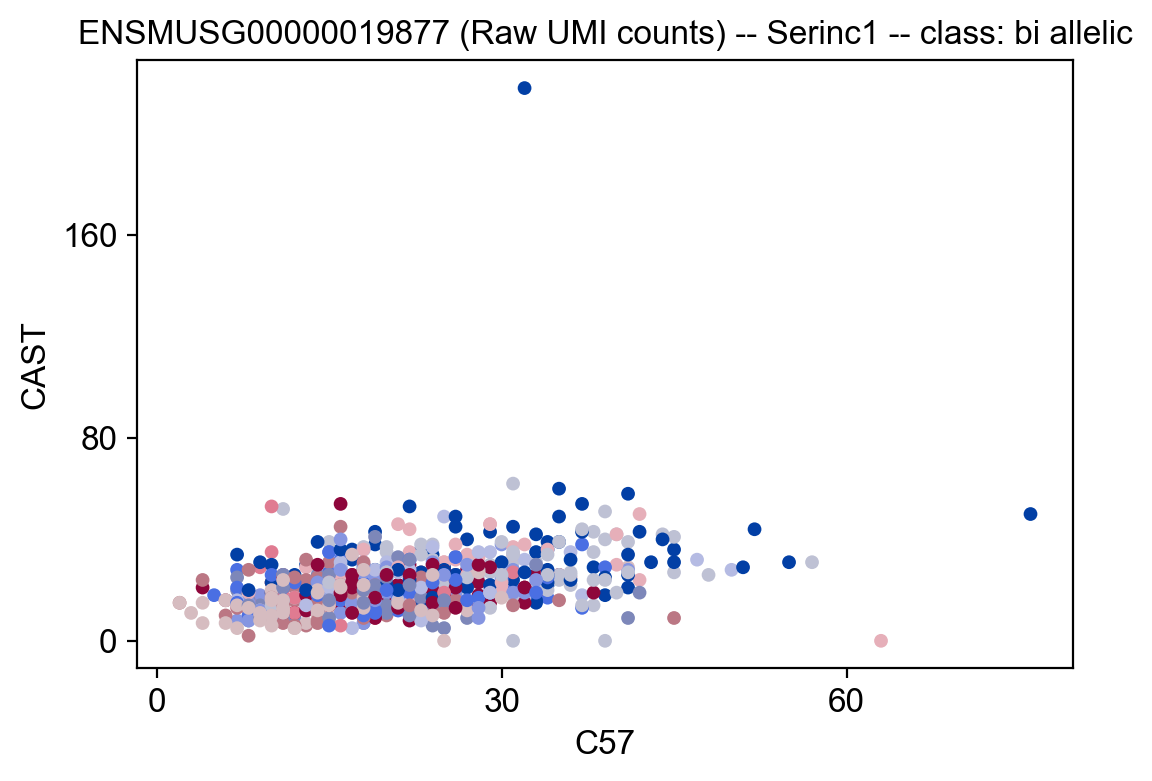

In [32]:
x = bi_allelic_index[random.randint(0,len(bi_allelic_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: bi_allelic")

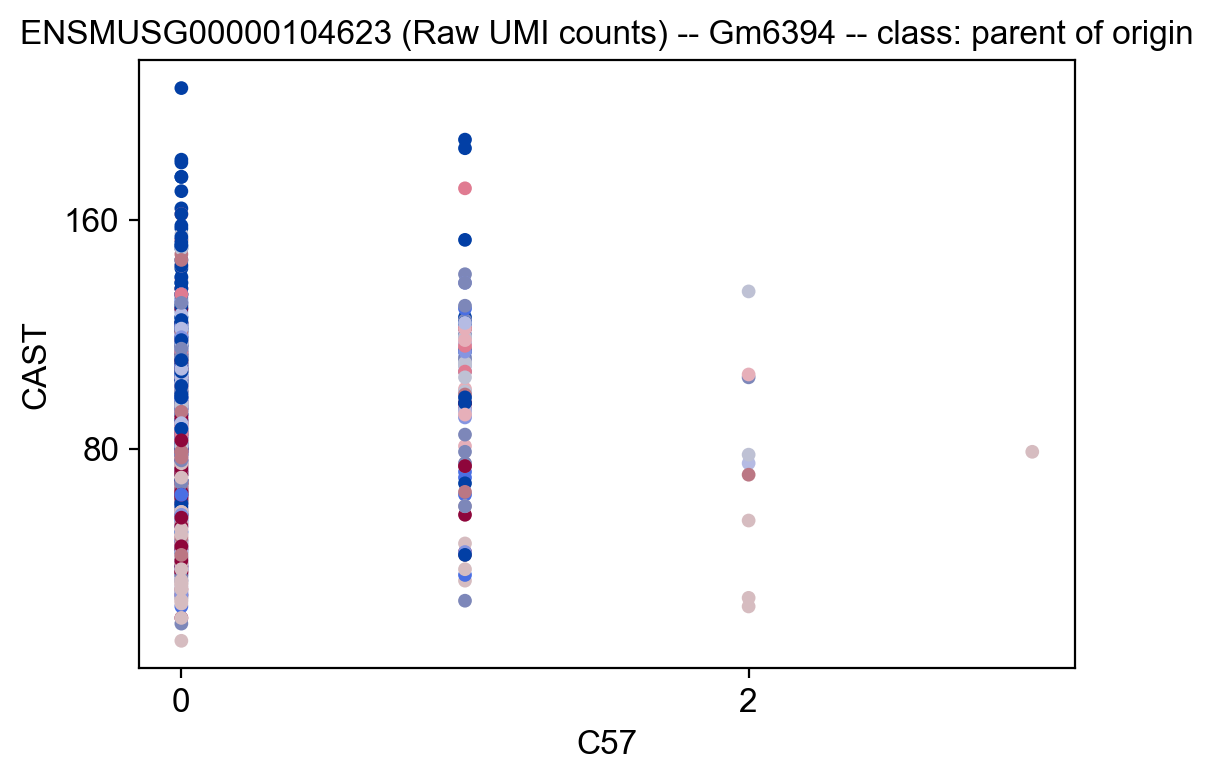

In [13]:
x = parent_of_origin_index[random.randint(0,len(parent_of_origin_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: parent_of_origin")

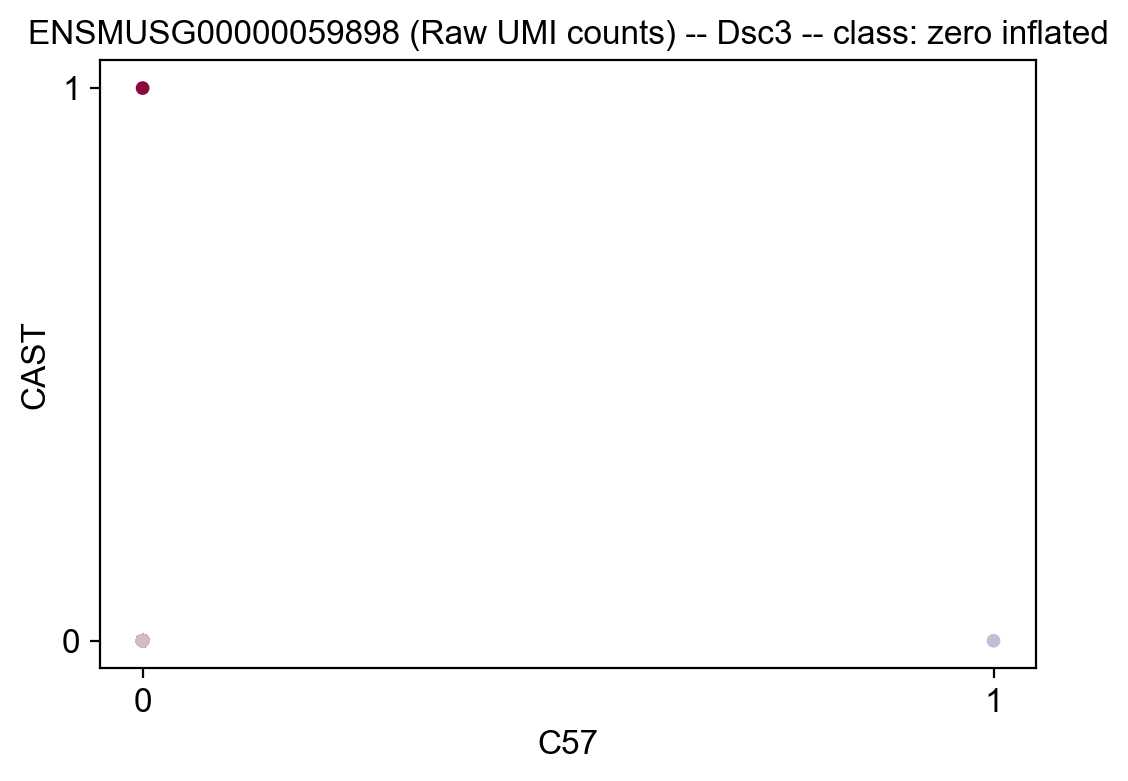

In [14]:
x = zero_inflated_index[random.randint(0,len(zero_inflated_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: zero_inflated")

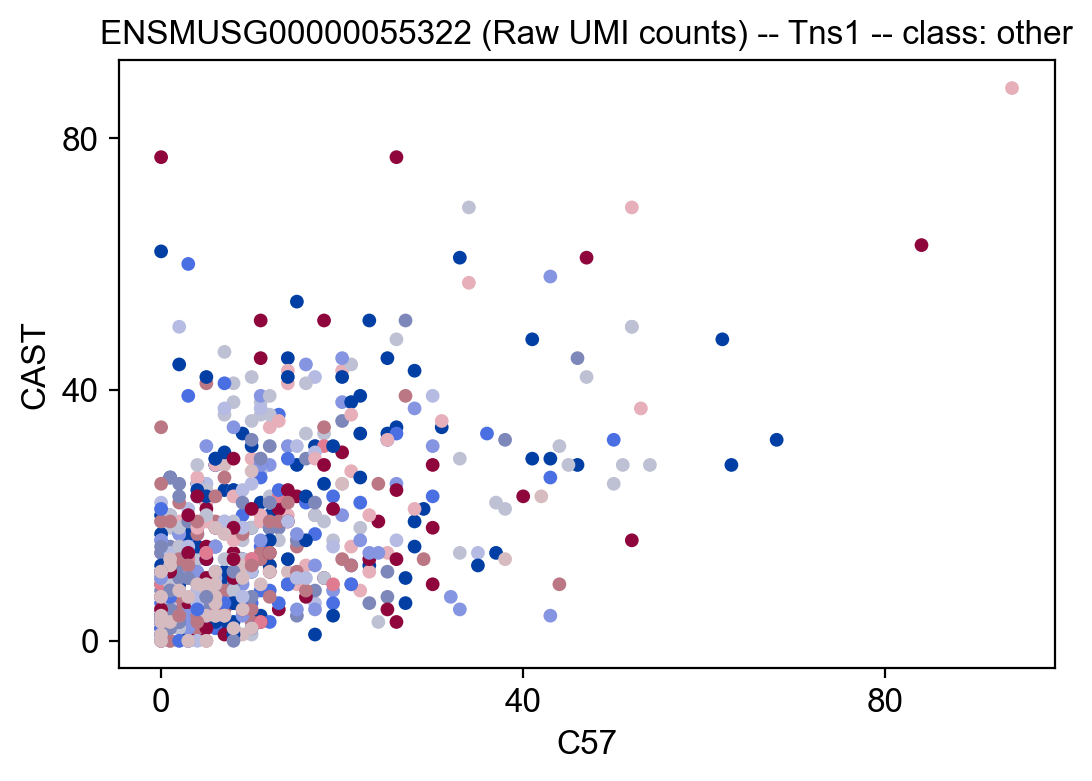

In [38]:
x = other_index[random.randint(0,len(other_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: other")

In [37]:
# labelling data

In [17]:
label = []
class_name = []
for x in adata.var.index:
    if x in bi_allelic_index:
        label.append(0)
    elif x in parent_of_origin_index:
        label.append(1)
    elif x in zero_inflated_index:
        label.append(3)
    else:
        label.append(2)
adata.var['class_label'] = label

In [18]:
adata.var.head(5)

,gene_name,chromosome,autosomes,nuclear,Ribosomal_prot,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2,p_value,class_label
ENSMUSG00000000001,Gnai3,3,autosome,nuclear,other protein,8956.0,10024.0,0.471865,0.528135,321.291178,360.708822,0.471101,0.528899,0.157535,0.157535,0.001223,0
ENSMUSG00000000049,Apoh,11,autosome,nuclear,other protein,46.0,48.0,0.489362,0.510638,29.500000,34.500000,0.460938,0.539062,0.498447,0.498447,1.000000,2
ENSMUSG00000000088,Cox5a,9,autosome,nuclear,other protein,7514.0,7028.0,0.516710,0.483290,350.605317,331.394683,0.514084,0.485916,0.151797,0.151797,0.089846,0
ENSMUSG00000000120,Ngfr,11,autosome,nuclear,other protein,0.0,4.0,0.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3
ENSMUSG00000000184,Ccnd2,6,autosome,nuclear,other protein,36198.0,33010.0,0.523032,0.476968,357.947744,324.052256,0.524850,0.475150,0.144606,0.144606,0.020103,0


In [19]:
# GEnerating shuffled training and test data for ml 

In [20]:
allele_1 = pd.DataFrame(adata.layers['spliced'], columns=adata.var.index)
allele_2 = pd.DataFrame(adata.layers['unspliced'], columns=adata.var.index)

In [21]:
allele_1_T = allele_1.transpose(copy=True)
allele_2_T = allele_2.transpose(copy=True)

In [22]:
# differentiating allele 1 and allele 2 UMI counts
allele_T = (allele_1_T - allele_2_T) / (allele_1_T + allele_2_T)

In [23]:
allele_T['class_label'] = adata.var['class_label']

In [24]:
allele_T.head(5)

,0,1,2,3,4,5,6,7,8,9,...,673,674,675,676,677,678,679,680,681,class_label
ENSMUSG00000000001,0.428571,-0.500000,-0.371429,-0.133333,0.142857,-0.260870,-0.174603,-0.478261,-0.052632,-0.333333,...,-0.428571,-0.066667,-0.090909,0.230769,-0.04,-0.100,0.142857,0.125000,0.166667,0
ENSMUSG00000000049,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
ENSMUSG00000000088,0.176471,0.571429,0.304348,0.333333,-0.200000,0.588235,0.296296,-0.280000,0.313433,-0.448276,...,0.000000,-1.000000,-0.200000,0.000000,0.00,0.000,-0.428571,-1.000000,0.333333,0
ENSMUSG00000000120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000000184,-0.284553,0.888889,-0.243902,0.082803,0.368421,-0.418919,0.576923,0.250000,-0.393939,-0.100000,...,0.020408,0.317073,0.162791,-0.081081,0.10,0.075,0.067797,-0.333333,-0.241379,0


In [25]:
test_set_1=allele_T[allele_T['class_label']==0].head(60).index
test_set_2=allele_T[allele_T['class_label']==1].head(8).index
test_set_3=allele_T[allele_T['class_label']==2].head(43).index
test_set_4=allele_T[allele_T['class_label']==3].head(83).index

test_set = test_set_1.union(test_set_2)
test_set = test_set.union(test_set_3)
test_set = test_set.union(test_set_4)
test_set = list(set(test_set))

test_set_suffled = random.sample(test_set, len(test_set))
test_set_suffled[:5]

['ENSMUSG00000002957',
 'ENSMUSG00000003549',
 'ENSMUSG00000000805',
 'ENSMUSG00000001493',
 'ENSMUSG00000023993']

In [26]:
test_set_csv = allele_T.loc[test_set_suffled]

In [27]:
test_set_csv.to_csv("data/classifier/test_set_7.csv", sep=";")

In [28]:
train_set = [x for x in list(allele_T.index) if x not in test_set_suffled]
len(train_set)

2940

In [29]:
train_set_suffled = random.sample(train_set, len(train_set))
train_set_suffled[:5]

['ENSMUSG00000028609',
 'ENSMUSG00000115206',
 'ENSMUSG00000025727',
 'ENSMUSG00000097092',
 'ENSMUSG00000036810']

In [30]:
train_set_csv = allele_T.loc[train_set_suffled]

In [31]:
train_set_csv.to_csv("data/classifier/train_set_7.csv", sep=";")